In [ ]:
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Lambda, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

2.15.0


In [ ]:
## Load MNIST dataset without flattening (reshaping) the images
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(X_train.shape)
print(X_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
## Hyperparameters for the model
batch_size = 256
max_epochs = 10
learning_rate = 1e-03
reg_strength = 0.1

In [ ]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
# Make train pairs
X_train_pairs, Y_train_pairs = make_pairs(X_train, y_train)

# Make test pairs
X_test_pairs, Y_test_pairs = make_pairs(X_test, y_test)



---

Function for visualizing the paired data (for function source, [click here](https://keras.io/examples/vision/siamese_contrastive/))


---



In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [ ]:
def initialize_base_siamese_network():
  input_layer = Input(shape = (28, 28, 1), name = 'input')
  layer = Flatten(name = 'flatten')(input_layer)
  layer = Dense(64, activation = tf.nn.leaky_relu, name = 'dense1')(layer)
  layer = Dropout(0.1, name = 'dropout1')(layer)
  layer = Dense(128, activation = tf.nn.leaky_relu, name = 'dense2')(layer)
  layer = Dropout(0.1, name = 'dropout2')(layer)
  layer = Dense(256, activation = tf.nn.leaky_relu, name = 'dense3')(layer)
  layer = Dense(512, activation = tf.nn.leaky_relu, name = 'dense4')(layer)

  return Model(inputs = input_layer, outputs = layer)

In [ ]:
 # Define Neural network architecture in a functional way
 def initialize_base_siamese_network():
    input_layer = Input(shape=(28, 28, 1), name='input')  # Add channel dimension
    x = BatchNormalization(name='batchnorm1')(input_layer)
    x = Conv2D(1, (3, 3), activation=tf.nn.leaky_relu, name='conv1')(x)
    x = MaxPooling2D((2, 2), name='maxpool1')(x)
    x = BatchNormalization(name='batchnorm2')(x)
    x = Conv2D(1, (3, 3), activation=tf.nn.leaky_relu, name='conv2')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten(name='flatten1')(x)
    x = BatchNormalization(name='batchnorm3')(x)
    return Model(inputs=input_layer, outputs=x)

In [ ]:
## Initializing the base siamese neural network
network = initialize_base_siamese_network()

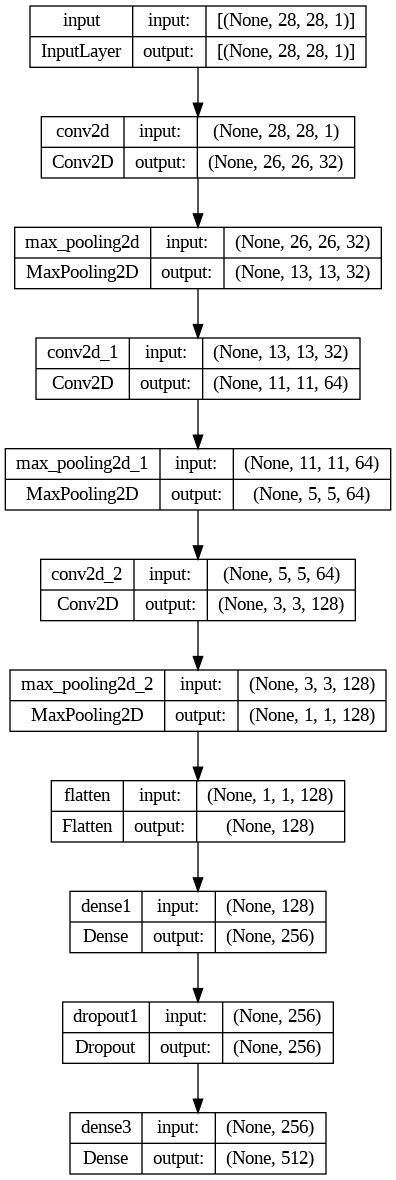

In [ ]:
## Plot the network
plot_model(network, show_shapes = True, show_layer_names=True, to_file = '/content/model.png')

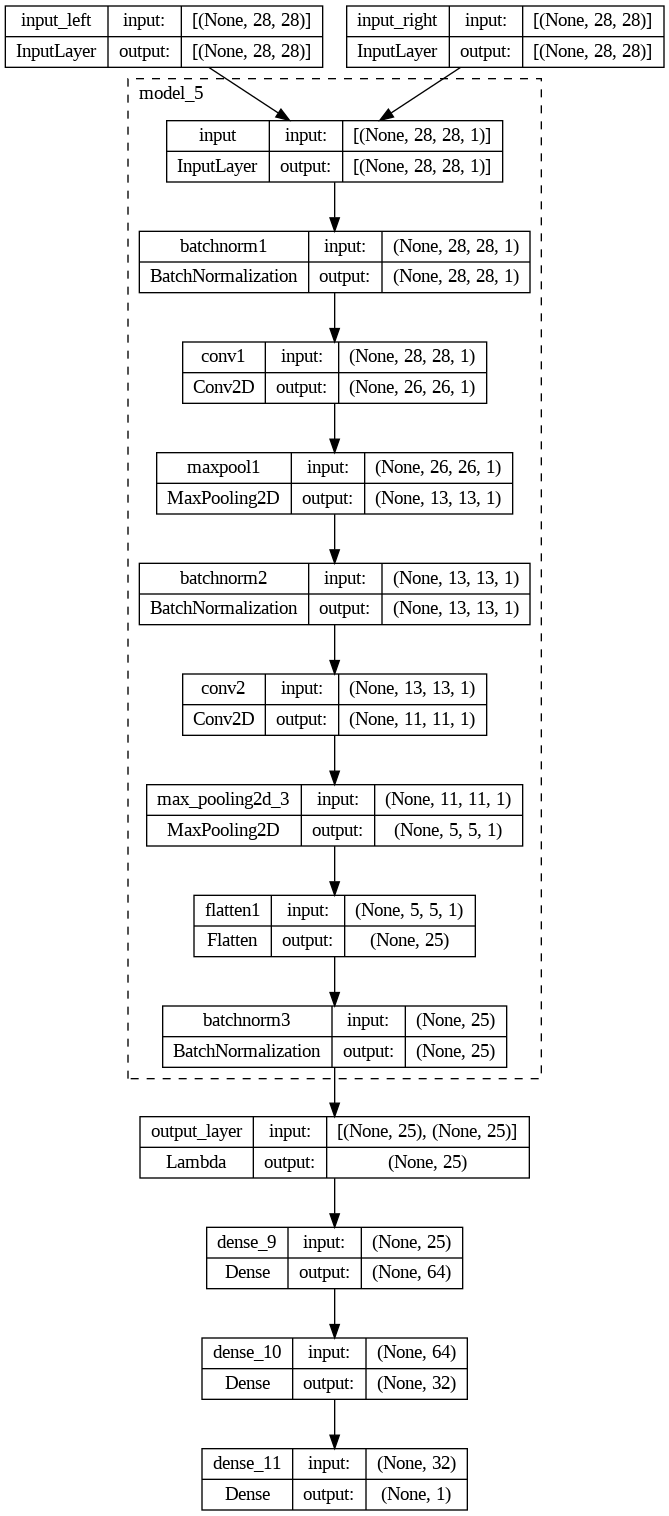

In [ ]:
## Build the siamese neural network architecture
input_left = Input(shape = (28, 28), name = 'input_left')
output_left = network(input_left)

input_right = Input(shape = (28, 28), name = 'input_right')
output_right = network(input_right)

# Measure the similarity of the outputs corresponding to
# inputs a and b
subtracted = Lambda(lambda x: x[0] - x[1], name = 'output_layer')([output_left, output_right])
dense = Dense(64, activation = tf.nn.leaky_relu)(subtracted)
dense = Dense(32, activation = tf.nn.leaky_relu)(dense)
output = Dense(1, activation = tf.nn.sigmoid)(dense)

# Specify the inputs and output of the siamese neural network
model = Model(inputs = [input_left, input_right], outputs = output)

# Plot the model
plot_model(model, show_shapes = True, show_layer_names=True, expand_nested = True)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate) # optimizer
loss_fn = tf.keras.losses.BinaryCrossentropy()  # loss function
model.compile(optimizer = opt, loss = loss_fn, metrics = ['acc'])

# Train model and simultaneously test on the test set
history = model.fit([X_train_pairs[:, 0], X_train_pairs[:, 1]],
                    Y_train_pairs,
                    batch_size = batch_size,
                    epochs = 10,
                    validation_data = ([X_test_pairs[:, 0], X_test_pairs[:, 1]], Y_test_pairs))

Epoch 1/10
469/469 [==============================] - 10s 13ms/step - loss: 0.6120 - acc: 0.6578 - val_loss: 0.5000 - val_acc: 0.7587
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.4528 - acc: 0.7893 - val_loss: 0.4229 - val_acc: 0.8043
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.4082 - acc: 0.8156 - val_loss: 0.3955 - val_acc: 0.8228
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3884 - acc: 0.8264 - val_loss: 0.3830 - val_acc: 0.8295
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3776 - acc: 0.8321 - val_loss: 0.3709 - val_acc: 0.8360
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3712 - acc: 0.8354 - val_loss: 0.3653 - val_acc: 0.8379
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3664 - acc: 0.8377 - val_loss: 0.3655 - val_acc: 0.8409
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 

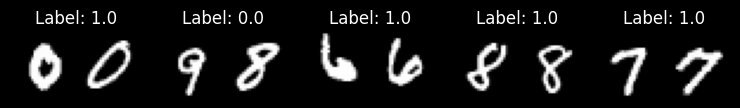

1/1 [==============================] - 0s 20ms/step


array([[0.9097804 ],
       [0.01227312],
       [0.6195564 ],
       [0.93104064],
       [0.9365003 ]], dtype=float32)

In [ ]:
# Visualize
ind = np.random.choice(X_test_pairs.shape[0], 5)
visualize(X_test_pairs[ind], Y_test_pairs[ind], to_show = len(ind), num_col = len(ind))
model.predict([X_test_pairs[ind, 0], X_test_pairs[ind, 1]])

In [ ]:
def initialize_base_siamese_network():
  input_layer = Input(shape = (28, 28, 1), name = 'input')
  layer = Conv2D(32, kernel_size = (3,3))(input_layer)
  layer = MaxPooling2D(pool_size=(2,2))(layer)
  layer = Conv2D(64, kernel_size = (3,3))(layer)
  layer = MaxPooling2D(pool_size=(2,2))(layer)
  layer = Conv2D(128, kernel_size = (3,3))(layer)
  layer = MaxPooling2D(pool_size=(2,2))(layer)
  layer = Flatten(name = 'flatten')(layer)
  layer = Dense(256, activation = tf.nn.leaky_relu, name = 'dense1')(layer)
  layer = Dropout(0.2, name = 'dropout1')(layer)
  layer = Dense(512, activation = tf.nn.leaky_relu, name = 'dense3')(layer)

  return Model(inputs = input_layer, outputs = layer)

In [ ]:
network = initialize_base_siamese_network()

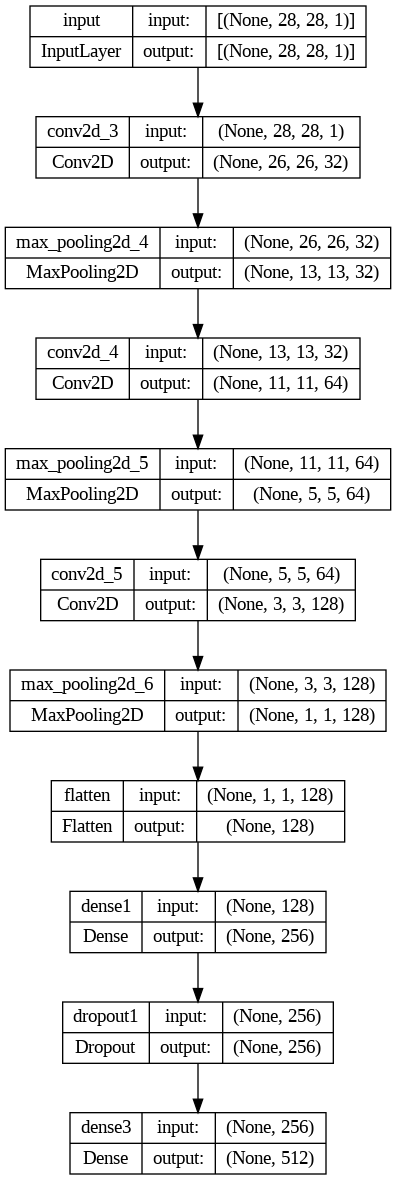

In [ ]:
## Plot the network
plot_model(network, show_shapes = True, show_layer_names=True)

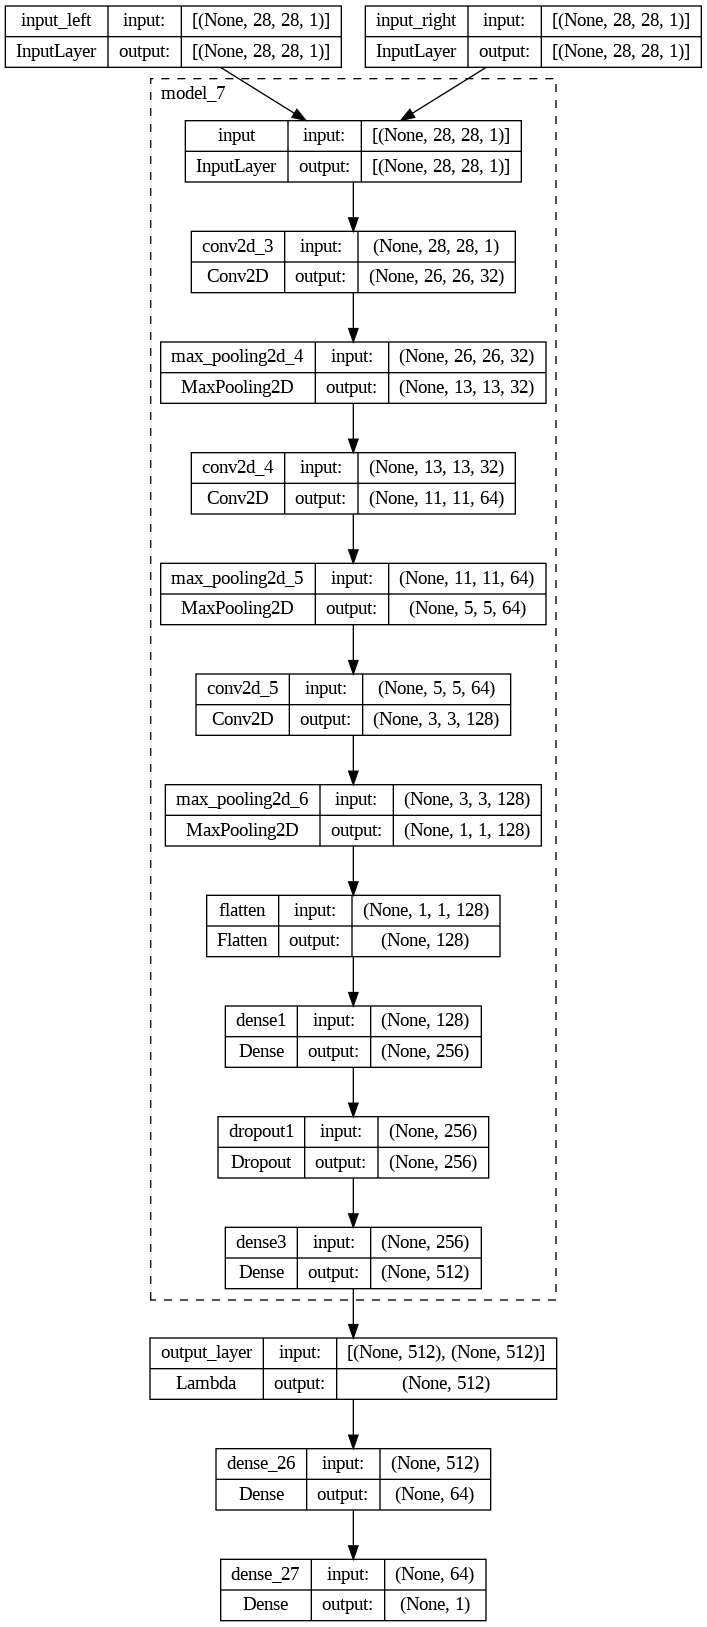

In [ ]:
## Build the siamese neural network architecture
input_left = Input(shape = (28, 28, 1), name = 'input_left')
output_left = network(input_left)

input_right = Input(shape = (28, 28, 1), name = 'input_right')
output_right = network(input_right)

# Measure the similarity of the outputs corresponding to
# inputs a and b
subtracted = Lambda(lambda x: x[0] - x[1], name = 'output_layer')([output_left, output_right])
dense = Dense(64, activation = tf.nn.leaky_relu)(subtracted)
#dense = Dense(32, activation = tf.nn.leaky_relu)(dense)
output = Dense(1, activation = tf.nn.sigmoid)(dense)

# Specify the inputs and output of the siamese neural network
model = Model(inputs = [input_left, input_right], outputs = output)

# Plot the model
plot_model(model, show_shapes = True, show_layer_names=True, expand_nested = True)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate) # optimizer
loss_fn = tf.keras.losses.BinaryCrossentropy()  # loss function
model.compile(optimizer = opt, loss = loss_fn, metrics = ['acc'])

# Train model and simultaneously test on the test set
history = model.fit([X_train_pairs[:, 0], X_train_pairs[:, 1]],
                    Y_train_pairs,
                    batch_size = batch_size,
                    epochs = 50,
                    validation_data = ([X_test_pairs[:, 0], X_test_pairs[:, 1]], Y_test_pairs))

Epoch 1/50
469/469 [==============================] - 8s 13ms/step - loss: 1.7797 - acc: 0.9487 - val_loss: 1.0710 - val_acc: 0.9723
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0817 - acc: 0.9939 - val_loss: 1.0421 - val_acc: 0.9737
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0961 - acc: 0.9947 - val_loss: 0.9732 - val_acc: 0.9800
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1093 - acc: 0.9943 - val_loss: 1.1399 - val_acc: 0.9791
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1587 - acc: 0.9937 - val_loss: 1.5516 - val_acc: 0.9740
Epoch 6/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1367 - acc: 0.9945 - val_loss: 1.1470 - val_acc: 0.9816
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1426 - acc: 0.9948 - val_loss: 1.3969 - val_acc: 0.9747
Epoch 8/50
469/469 [==============================] - 6s 12ms/step - 

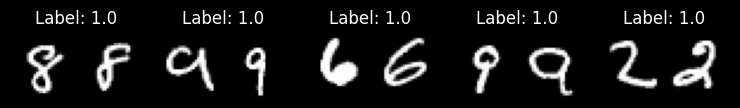

1/1 [==============================] - 0s 447ms/step


array([[0.9998933 ],
       [0.9997899 ],
       [0.99998665],
       [0.9829301 ],
       [0.99911076]], dtype=float32)

In [ ]:
# Visualize
ind = np.random.choice(X_test_pairs.shape[0], 5)
visualize(X_test_pairs[ind], Y_test_pairs[ind], to_show = len(ind), num_col = len(ind))
model.predict([X_test_pairs[ind, 0], X_test_pairs[ind, 1]])